# Introduction to Survey Simulations

**Note**: this tutorial currently requires the 18.11 software release; it doesn't yet work with the newer surveysim/desisurvey in the 18.12 and 19.2 releases.

The goal of this notebook is to introduce you to the outputs available from DESI "survey simulations". These are the fastest type of DESI simulation to run and only involve the following components:
 - Simulated stochastic weather (seeing, transparency, ...). See [DESI-3087](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=3087) for details.
 - Afternoon planning, which updates tile observing priorities and schedules fiber assignment.
 - Next tile selector, which determines which tile to observe next, based on recent progress and current weather.
 
The software for these components is mostly in the [desisurvey](https://desisurvey.readthedocs.io) and [surveysim](https://surveysim.readthedocs.io) packages.  Note that survey simulations operate at the level of tiles, not targets, and never generate spectra or redshifts and do not refer to any input catalog.  For a recent overview of the different DESI simluation types, see [DESI-3377](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=3377).

This tutorial focuses on the using the outputs of a survey simulation. After working with the outputs from some existing simulations, you might want to run your own survey simulations: that tutorial is [here](http://surveysim.readthedocs.io/en/latest/tutorial.html).  For other tutorials, covering topics such as simulating your own DESI spectra, see [this list](https://github.com/desihub/tutorials/blob/master/README.md).

For general questions and suggestions on this tutorial, email desi-data@desi.lbl.gov. For more specific suggestions or bug reports, please [create a github issue](https://github.com/desihub/tutorials/issues).

## Getting Started

This notebook is optimized for use with the jupyter-dev service at NERSC, which provides pre-installed DESI software running in a jupyter notebook. If this is your first time using jupyter-dev at NERSC, follow [these instructions](https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC) to get it configured.

If you prefer to work on your laptop, you will need to [install the necessary DESI software locally](https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop).

**If you are working through this notebook in a live jupyter session, I recommend removing all the output below for a more interactive experience.** Use the "Cell > Current Outputs > Clear" menu item.

**There are several exercises below for you to work on once you master the basics.**

#### DESI Version Compatibility

- 2017-12-04 : tested using the `DESI master` kernel on jupyter-dev with the `surveysim2017/depth_0m/` outputs.
- 2018-03-30 : tested using the `DESI 18.3` kernel on jupyter-dev with the `surveysim2017/depth_0m/` outputs (which were generated with an earlier version of the code).
- 2018-07-20 : tested using the `DESI 18.6` kernel on jupyter-dev with the `surveysim2017/depth_0m/` outputs (which were generated with an earlier version of the code).
- 2018-10-15 : tested using the `DESI 18.7` kernel on jupyter-dev with the `surveysim2017/depth_0m/` outputs (which were generated with an earlier version of the code).
- 2019-03-22 : tested using the `DESI 18.11` kernel.  It currently does *not* work with the
`18.12` or `19.2` kernels.

### Load Modules

Import numpy and matplotlib and draw plots directly to the notebook:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Import the `desisurvey` modules we need below:

In [2]:
import desisurvey.progress
import desisurvey.utils
import desisurvey.plots

Ignore expected harmless warnings (or don't run these lines if you prefer to see them):

In [3]:
import warnings, matplotlib.cbook, astropy._erfa.core
warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings('ignore', category=astropy._erfa.core.ErfaWarning)

### Find Simulation Outputs

Identify which survey simulation you want to study by setting the `$DESISURVEY_OUTPUT` environment variable:
 - `depth_0m`: Simulates a simple depth-first survey strategy for one random weather realization.
 - `baseline_1m`: Simulates the baseline survey strategy described in DESI-doc-1767-v3 for one random weather realization.
 
The `0m` and `1m` in the name refer to the fiber assignment (FA) cadence policy (see [DESI-3194](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=3194) for details):
 - `m` indicates that FA is run on a monthly cadence (during the 7-night full moon shutdowns).  Other options are `d` (daily) and `q` (quarterly = every 3 full moons).
 - `0` or `1`  indicates the number of complete (daily/monthly/quarterly) cycles that must elapse after a tile is completely covered by earlier tiles (so that decisions about reobserving QSOs, etc, can be made) before it will have its fibers assigned.  A delay of `0` indicates that FA is run as soon as possible, at the next cycle.
 
Note that `$DESISURVEY_OUTPUT` is only read the first time you use a `desisurvey` function, so the easiest way to make a change below take effect is to restart the jupyter kernel and re-run the initial cells.

In [4]:
import os
os.environ['DESISURVEY_OUTPUT'] = '/global/projecta/projectdirs/desi/datachallenge/surveysim2017/depth_0m/'

## Survey Progress

The main output from a survey simulation is a FITS file that records the simulated survey progress. Progress is organized around **tiles** and **exposures**.  Tiles are predefined ([DESI-717](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=717)) to cover the whole survey footprint in 8 dithered passes. Each tile is observed with one or more exposures.  Multiple exposures of a tile are sometimes required to:
 - Split a long exposure to minimize the impact of cosmic rays.
 - Continue an exposure that is terminated early due to a program change (or dawn).
 - Continue an exposure that is found to have insufficient signal to noise after pipeline processing.

After setting `$DESISURVEY_OUTPUT`, load the corresponding progress using:

In [5]:
progress = desisurvey.progress.Progress(restore='progress.fits')

INFO:progress.py:145:__init__: Loaded progress from /global/projecta/projectdirs/desi/datachallenge/surveysim2017/depth_0m/progress.fits.


The returned object has some useful summary methods and attributes, for example:

In [6]:
print('Survey runs {} to {} and observes {} tiles with {} exposures'
      .format(
          desisurvey.utils.get_date(progress.first_mjd),
          desisurvey.utils.get_date(progress.last_mjd),
          progress.num_tiles, progress.num_exp))

Survey runs 2019-12-01 to 2024-08-28 and observes 16071 tiles with 26791 exposures


Note that progress uses MJD timestamps internally, which can be converted to dates using [`desisurvey.utils.get_date()`](http://desisurvey.readthedocs.io/en/latest/api.html?highlight=get_date#desisurvey.utils.get_date).

In [7]:
def progress_report(progress=progress):
    for program, passes in dict(DARK=(0,1,2,3), GRAY=(4,), BRIGHT=(5,6,7)).items():
        stats = progress.completed(only_passes=passes, as_tuple=True)
        print('Observed {:6.1f} / {} tiles ({:.1f}%) of the {} program '
              .format(*stats, program))
        
progress_report()

Observed 8038.0 / 8038 tiles (100.0%) of the DARK program 
Observed 2005.0 / 2005 tiles (100.0%) of the GRAY program 
Observed 6028.0 / 6028 tiles (100.0%) of the BRIGHT program 


The progress after the survey completes (100%!) is not very interesting but you can also see progress over any time interval using the `copy_range()` method:

In [8]:
help(progress.copy_range)

Help on method copy_range in module desisurvey.progress:

copy_range(mjd_min=None, mjd_max=None) method of desisurvey.progress.Progress instance
    Return a copy of progress during a date range.
    
    Parameters
    ----------
    mjd_min : float or None
        Only include exposures with mjd >= mjd_min.
    mjd_max : float
        Only include exposures with mjd < mjd_max.
    
    Returns
    -------
    Progress
        New object with any exposures outside the specified MJD range
        zeroed out and ``status`` values updated accordingly.



Use this method to get a progress report after the first year of the survey:

In [9]:
year1 = progress.copy_range(progress.first_mjd, progress.first_mjd + 365)
progress_report(year1)

Observed 2026.3 / 8038 tiles (25.2%) of the DARK program 
Observed  508.8 / 2005 tiles (25.4%) of the GRAY program 
Observed 1923.7 / 6028 tiles (31.9%) of the BRIGHT program 


The progress object is internally organized as an [astropy table](http://docs.astropy.org/en/stable/table/) with one row per tile:

In [10]:
progress._table[:3]

tileid,pass,ra,dec,status,covered,available,planned,mjd [32],exptime [32],snr2frac [32],airmass [32],seeing [32],transparency [32],moonfrac [32],moonalt [32],moonsep [32]
,,,,,,,,,s,,,arcsec,,,deg,deg
int32,int16,float64,float64,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64
4,0,335.03,19.88,2,0,0,0,59495.1695277 .. 0.0,926.315392585 .. 0.0,0.478554368557 .. 0.0,1.03281434828 .. 0.0,0.931928694248 .. 0.0,0.713409125805 .. 0.0,0.0466595995838 .. 0.0,-23.6345571128 .. 0.0,121.455038659 .. 0.0
6,0,333.22,14.84,2,0,0,0,59141.1313538 .. 0.0,877.823028666 .. 0.0,0.582571826855 .. 0.0,1.06023666254 .. 0.0,0.890431463718 .. 0.0,0.998891413212 .. 0.0,0.0902869406183 .. 0.0,-6.97811498488 .. 0.0,101.031105413 .. 0.0
7,0,332.35,12.32,2,0,0,0,59111.2096372 .. 0.0,861.241616678 .. 0.0,0.466055692419 .. 0.0,1.07749604235 .. 0.0,1.3211607933 .. 0.0,0.994240820408 .. 0.0,0.0513034604722 .. 0.0,-28.5849483233 .. 0.0,131.564033405 .. 0.0


The structure of this table is designed around the needs of the operations software, but some user-oriented views are provided by two methods:

In [11]:
help(progress.get_summary)

Help on method get_summary in module desisurvey.progress:

get_summary(include='observed') method of desisurvey.progress.Progress instance
    Get a per-tile summary of progress so far.
    
    Returns a new table so any modifications are decoupled from our
    internal table.  Exposure MJD values are summarized as separate
    ``mjd_min`` and ``mjd_max`` columns, with both equal to zero for
    un-observed tiles. The summary ``exptime`` and ``snr2frac`` columns
    are sums of the individual exposures.  The summary ``airmass``,
    ``seeing`` and ``transparency`` columns are means. A ``nexp`` column
    counts the number of exposures for each tile.  The moon parameters are
    not summarized.
    
    Can be combined with :meth:`copy_range` to summarize observations during
    a range of dates.
    
    Parameters
    ----------
    include : 'all', 'observed', or 'completed'
        Specify which tiles to include in the summary. The 'observed'
        selection will include tiles th

In [12]:
help(progress.get_exposures)

Help on method get_exposures in module desisurvey.progress:

get_exposures(start=None, stop=None, tile_fields='tileid,pass,ra,dec,ebmv', exp_fields='night,mjd,exptime,seeing,transparency,airmass,moonfrac,moonalt,moonsep,program,flavor') method of desisurvey.progress.Progress instance
    Create a table listing exposures in time order.
    
    Parameters
    ----------
    start : date or None
        First date to include in the list of exposures, or date of the
        first observation if None.
    stop  : date or None
        Last date to include in the list of exposures, or date of the
        last observation if None.
    tile_fields : str
        Comma-separated list of per-tile field names to include. The
        special name 'index' denotes the index into the visible tile array.
        The special name 'ebmv' adds median E(B-V) values for each tile
        from the tile design file.
    exp_fields : str
        Comma-separated list of per-exposure field names to include. The


Create these views now. The next sections show how to use them.

In [13]:
summary = progress.get_summary()

In [14]:
exposures = progress.get_exposures()

## Progress Summary

The summary table has one row per tile containing summary statistics of all exposures (if any) of that tile:

In [15]:
summary[:3]

tileid,pass,ra,dec,status,covered,available,planned,mjd_min,mjd_max,exptime,snr2frac,airmass,seeing,transparency,nexp
,,,,,,,,,,s,,,arcsec,,
int32,int16,float64,float64,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,int64
4,0,335.03,19.88,2,0,0,0,59495.1695277,59495.1816378,2016.66278611,1.04185118149,1.03281434828,0.931928694248,0.713409125805,2
6,0,333.22,14.84,2,0,0,0,59141.1313538,59141.1429027,1448.39948441,0.961237864685,1.06023666254,0.890431463718,0.998891413212,2
7,0,332.35,12.32,2,0,0,0,59111.2096372,59111.2209942,1776.45936855,0.961320243972,1.07749604235,1.3211607933,0.994240820408,2


The primary metric used to set the goal total exposure time for each tile is signal-to-noise ratio (SNR) for a set of predefined "threshold targets":
 - DARK & GRAY programs: ELGs with integrated \[OII\] flux of 8e-17 erg/(s cm^2)
 - BRIGHT program: BGS targets with r=19.5 and no emission lines
 
Plot the ratio of actual / goal SNR for each tile:

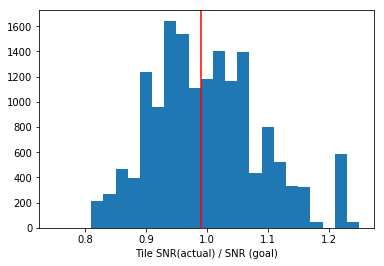

In [16]:
plt.hist(summary['snr2frac'], range=(0.75, 1.25), bins=25)
plt.xlabel('Tile SNR(actual) / SNR (goal)')
plt.axvline(np.median(summary['snr2frac']), c='r');

Plot the corresponding total exposure times, which shows two peaks for the BRIGHT and DARK+GRAY programs:

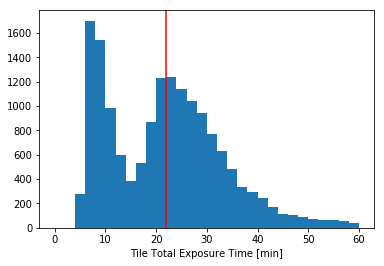

In [17]:
plt.hist(summary['exptime'] / 60, range=(0, 60), bins=30)
plt.xlabel('Tile Total Exposure Time [min]')
plt.axvline(np.median(summary['exptime'] / 60), c='r');

To plot the distribution of any column's values over the sky, separately for each of the 8 passes, use `plot_sky_passes`:

In [18]:
help(desisurvey.plots.plot_sky_passes)

Help on function plot_sky_passes in module desisurvey.plots:

plot_sky_passes(ra, dec, passnum, z, clip_lo=None, clip_hi=None, label='label', cmap='viridis', save=None)
    Plot sky maps for each pass of a per-tile scalar quantity.
    
    The matplotlib and basemap packages must be installed to use this function.
    
    Parameters
    ----------
    ra : array
        Array of RA values to use in degrees.
    dec : array
        Array of DEC values to use in degrees.
    pass : array
        Array of integer pass values to use.
    z : array
        Array of per-tile values to plot.
    clip_lo : float or string or None
        See :meth:`desiutil.plot.prepare_data`
    clip_hi : float or string or None
        See :meth:`desiutil.plot.prepare_data`
    label : string
        Brief description of per-tile value ``z`` to use for axis labels.
    cmap : colormap name or object
        Matplotlib colormap to use for mapping data values to colors.
    save : string or None
        Name

For example, to see the distributions of SNR(actual) / SNR(goal) over the sky after year 1 (this function takes ~30s to run):

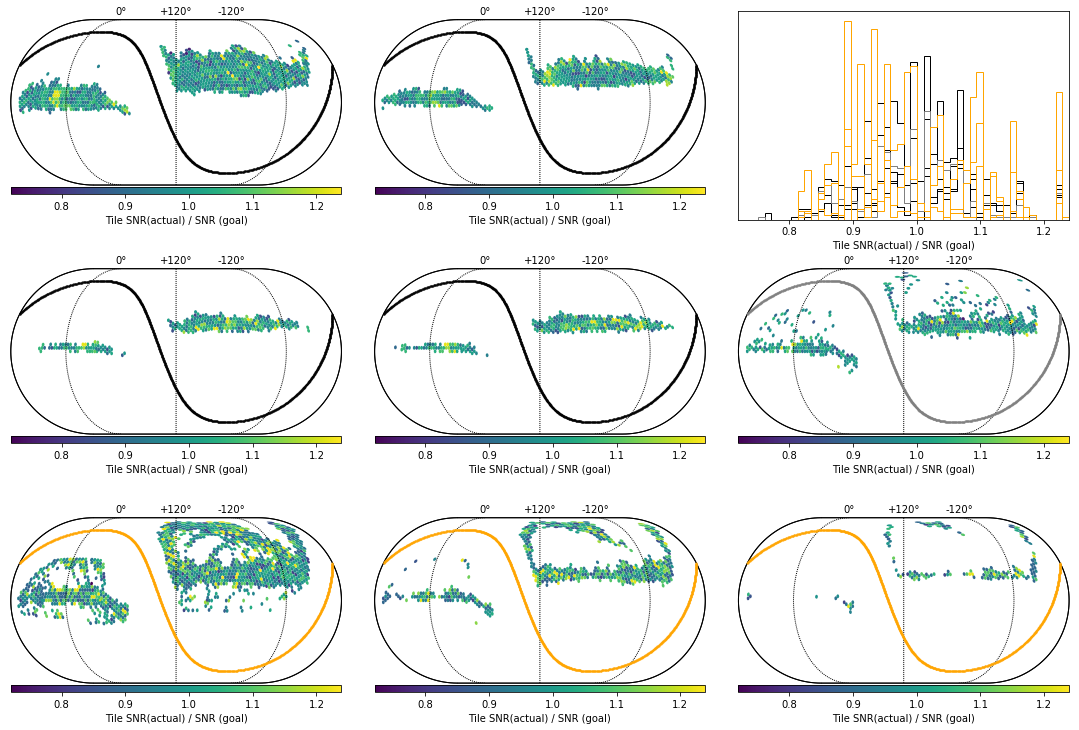

In [19]:
year1_summary = year1.get_summary()
desisurvey.plots.plot_sky_passes(
    year1_summary['ra'], year1_summary['dec'], year1_summary['pass'],
    year1_summary['snr2frac'], label='Tile SNR(actual) / SNR (goal)');

For more control of sky plots like this, see [this tutorial](https://github.com/desihub/desiutil/blob/master/doc/nb/SkyMapExamples.ipynb) on the lower-level `desiutil.plots` functions being used.

The following columns summarize the afternoon planning and scheduling of fiber assignment (FA):
 - covered: Date the tile is first covered by previous layers and thus eligible for FA.
 - available: Date the tile first has fibers assigned.
 - planned: Date the tile is first included in the observing plan.
 
All dates are specified as an integer number of days from the survey start date (defined by [this utility function](http://desisurvey.readthedocs.io/en/latest/api.html#desisurvey.utils.day_number)).  As an example, plot the number of days into the survey that each tile is covered:

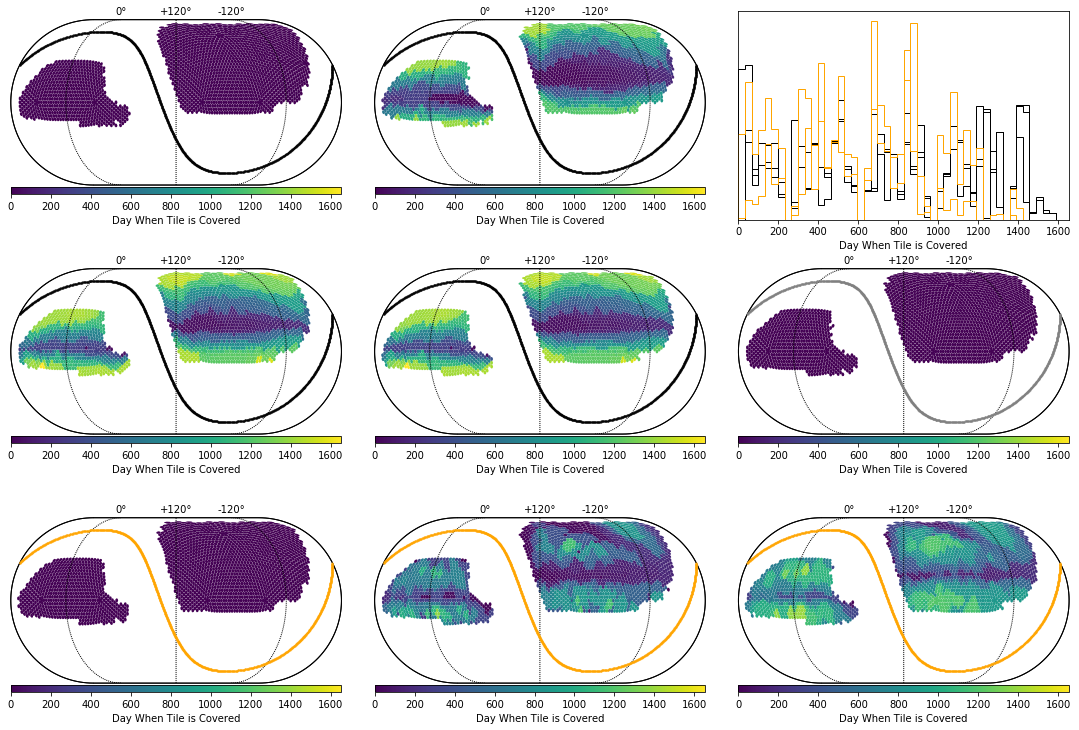

In [20]:
desisurvey.plots.plot_sky_passes(
    summary['ra'], summary['dec'], summary['pass'],
    summary['covered'], label='Day When Tile is Covered');

Note that the depth-first strategy has all tiles planned (=0) at the start of the survey, but other strategies have more complex dependencies between different regions of the sky in each pass.

### Exercises

In [21]:
# Plot a histogram of the number of exposures of each tile in the full survey.

In [22]:
# Plot histograms of snr2frac after year-1 separately for the DARK, GRAY, BRIGHT programs.

In [23]:
# Create all-sky plots of the mean airmass that each tile was observed at in the full survey.

In [24]:
# Study the tile "overhead", defined as 86400 * (mjd_max - mjd_min) - exptime.

## Exposures List

The exposures list is a table with rows corresponding to each simulated exposure, in increasing time order, with columns for their simulated observing conditions. Note that column names are all UPPER CASE.

In [25]:
exposures[:3]

TILEID,PASS,RA,DEC,EBMV,NIGHT,MJD,EXPTIME,SEEING,TRANSPARENCY,AIRMASS,MOONFRAC,MOONALT,MOONSEP,PROGRAM,FLAVOR
,,,,,,,s,arcsec,,,,deg,deg,,
int32,int16,float64,float64,float32,str8,float64,float64,float64,float64,float64,float64,float64,float64,str6,str7
34308,5,345.64,25.37,0.145557,20191201,58819.0583701,686.255885087,0.993969678879,0.965001940727,1.01068331726,0.315489669913,34.1941411183,52.6531193026,BRIGHT,science
23195,4,343.4,30.09,0.0609376,20191201,58819.0677018,789.74873144,0.975707352161,0.898529052734,1.00053691614,0.315489669913,33.1271733079,55.6211758454,GRAY,science
23195,4,343.4,30.09,0.0609376,20191201,58819.0782313,826.022135193,0.975707352161,0.898529052734,1.00053691614,0.315489669913,33.1271733079,55.6211758454,GRAY,science


To see the distribution of individual exposure times (and compare with the total exposure time plot above), use:

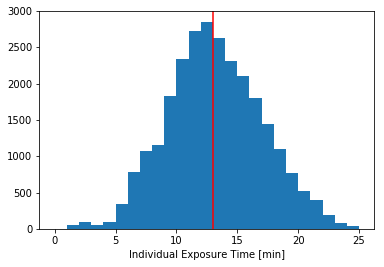

In [26]:
plt.hist(exposures['EXPTIME'] / 60, range=(0, 25), bins=25)
plt.xlabel('Individual Exposure Time [min]')
plt.axvline(np.median(exposures['EXPTIME'] / 60), c='r');

To see the distribution of atmospheric seeing during the simulated survey, use:

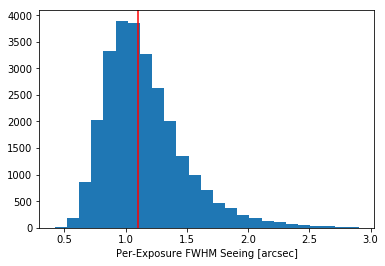

In [27]:
plt.hist(exposures['SEEING'], bins=25)
plt.xlabel('Per-Exposure FWHM Seeing [arcsec]')
plt.axvline(np.median(exposures['SEEING']), c='r');

To study the correlation between  exposure time and seeing in the first DARK pass, use:

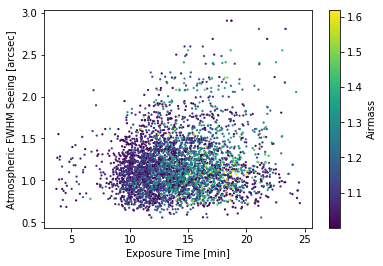

In [28]:
pass1 = exposures[exposures['PASS'] == 0]
plt.scatter(pass1['EXPTIME'] / 60, pass1['SEEING'], c=pass1['AIRMASS'], lw=0, s=5);
plt.colorbar().set_label('Airmass')
plt.xlabel('Exposure Time [min]')
plt.ylabel('Atmospheric FWHM Seeing [arcsec]');

### Exercises

In [29]:
# Study the correlation between exposure time and moon altitude (which is underestimated in these simulations)

In [30]:
# Plot histograms of the number of exposures per night in each program.

In [31]:
# Study how often GRAY and BRIGHT exposures are taken with no moon in the sky.

In [32]:
# Study which of the 3 moon parameters correlates most strongly with exposure time.